In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler


seed = 331

In [2]:
def resultPlot(x_name, x, fnr, fpr, roc_auc, sensitivities, specificities):
    fig = plt.figure(figsize = (13, 8))
    
    colors = ['r', 'g', 'b', 'c', 'm']

    plt.plot(x, fnr, color=colors[0], marker='.', label ='FNR')
    plt.plot(x, fpr, color=colors[1], marker='.', label ='FPR')
    plt.plot(x, roc_auc, color=colors[2], marker='.', label ='ROC AUC')
    plt.plot(x, sensitivities, color=colors[3], marker='.', label ='Sensitivity')
    plt.plot(x, specificities, color=colors[4], marker='.', label ='Specificity')

    # # Adding Xticks
    plt.xlabel(x_name, fontweight ='bold', fontsize = 15)
    plt.ylabel('Value', fontweight ='bold', fontsize = 15)
#     plt.yticks(list(range(0, 1, 0.1)))
    plt.xticks([x[i] for i in range(1,len(x),2)])

    plt.grid()
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.)
    plt.show()

In [3]:
def fnr_calc(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    return fn / (fn + tp)

def fpr_calc(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    return fp / (fp + tn)



def model_metrics(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tp + tn)
    
    return fnr, fpr, roc_auc, sensitivity, specificity

# Data preparation

In [4]:
dataframe = pd.read_csv("./data/creditcard.csv")

columns = dataframe.columns.drop('Class')

dataframe.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
scaled_dataframe = dataframe.copy().drop(['Class'],axis=1)

transformer = StandardScaler()

transformer.fit(scaled_dataframe)

scaled_dataframe = transformer.transform(scaled_dataframe)
scaled_dataframe = pd.DataFrame(scaled_dataframe, columns=columns)

In [6]:
X = scaled_dataframe
y = dataframe.Class

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed, test_size=0.33)

print("train rows: {}, test rows: {}".format(X_train.shape[0], X_test.shape[0]))

train rows: 190820, test rows: 93987


# Testing MLP classifier

In [7]:
mlp = MLPClassifier(random_state=seed)
mlp.fit(X_train, y_train)

mlp.score(X_test, y_test)

0.9995850489961378

In [9]:
y_pred = mlp.predict(X_test)

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
cm

array([[  128,    29],
       [   10, 93820]], dtype=int64)

In [11]:
fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr * 100, fpr * 100))
print("ROC AUC = {:.4f}".format(roc_auc * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity * 100, specificity * 100))

FNR = 18.4713%, FPR = 0.0107%
ROC AUC = 90.7590
sensitivity = 81.5287%, specificity = 99.8638%


## Testing other MLP classifier settings

In [20]:
layer1 = np.linspace(1, 60, 60).astype(int)

fnrs_1 = []
fprs_1 = []
roc_aucs_1 = []
sensitivities_1 = []
specificities_1 = []

for neurons in layer1:
    mlp = MLPClassifier(solver='adam', hidden_layer_sizes=[neurons, ], max_iter=200, batch_size=700, random_state = seed)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_1.append(fnr)
    fprs_1.append(fpr)
    roc_aucs_1.append(roc_auc)
    sensitivities_1.append(sensitivity)
    specificities_1.append(specificity)

In [21]:
min_fnr = 100
best_param = 0
for i in range(len(fnrs_1)):
    if (fprs_1[i] * 100 < 0.5 and fnrs_1[i] < min_fnr):
        min_fnr = fnrs_1[i]
        best_param = i
        
print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnrs_1[best_param] * 100, fprs_1[best_param] * 100))
print("ROC AUC = {:.4f}".format(roc_aucs_1[best_param] * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivities_1[best_param] * 100, specificities_1[best_param] * 100))

print("Best layer1 neurons num = {:.4f}".format(layer1[best_param]))

best_layer1 = layer1[best_param]

mlp1 = MLPClassifier(solver='adam', hidden_layer_sizes=[best_layer1, ], max_iter=200, batch_size=700, random_state = seed)
mlp1.fit(X_train, y_train)
y_pred_best = mlp1.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best, labels=[1,0])
cm

FNR = 16.5605%, FPR = 0.0096%
ROC AUC = 91.7149
sensitivity = 83.4395%, specificity = 99.8606%
Best layer1 neurons num = 56.0000


array([[  131,    26],
       [    9, 93821]], dtype=int64)

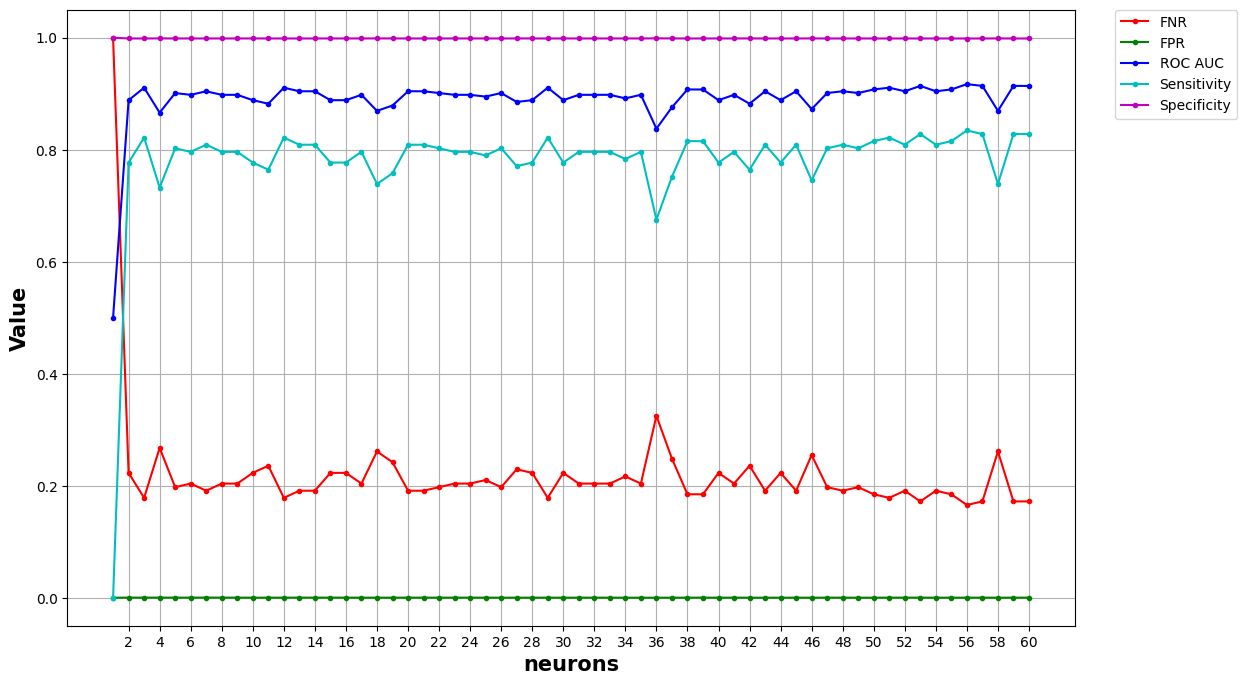

In [77]:
resultPlot('neurons', layer1, fnrs_1, fprs_1, roc_aucs_1, sensitivities_1, specificities_1)

In [23]:
layer2 = np.linspace(60, 120, 61).astype(int)

fnrs_2 = []
fprs_2 = []
roc_aucs_2 = []
sensitivities_2 = []
specificities_2 = []

for neurons in layer2:
    mlp = MLPClassifier(solver='adam', hidden_layer_sizes=[best_layer1, neurons, ], max_iter=200, batch_size=700, random_state = seed)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_2.append(fnr)
    fprs_2.append(fpr)
    roc_aucs_2.append(roc_auc)
    sensitivities_2.append(sensitivity)
    specificities_2.append(specificity)

In [79]:
min_fnr = 100
best_param = 0
for i in range(len(fnrs_2)):
    if (fprs_2[i] * 100 < 0.5 and fnrs_2[i] < min_fnr):
        min_fnr = fnrs_2[i]
        best_param = i
        
print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnrs_2[best_param] * 100, fprs_2[best_param] * 100))
print("ROC AUC = {:.4f}".format(roc_aucs_2[best_param] * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivities_2[best_param] * 100, specificities_2[best_param] * 100))

print("Best layer2 neurons num = {}".format(layer2[best_param]))

best_layer2 = layer2[best_param]

mlp2 = MLPClassifier(solver='adam', hidden_layer_sizes=[best_layer1, best_layer2, ], max_iter=200, batch_size=700, random_state = seed)
mlp2.fit(X_train, y_train)
y_pred_best = mlp2.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best, labels=[1,0])
cm

FNR = 15.9236%, FPR = 0.0277%
ROC AUC = 92.0244
sensitivity = 84.0764%, specificity = 99.8595%
Best layer2 neurons num = 62


array([[  132,    25],
       [   26, 93804]], dtype=int64)

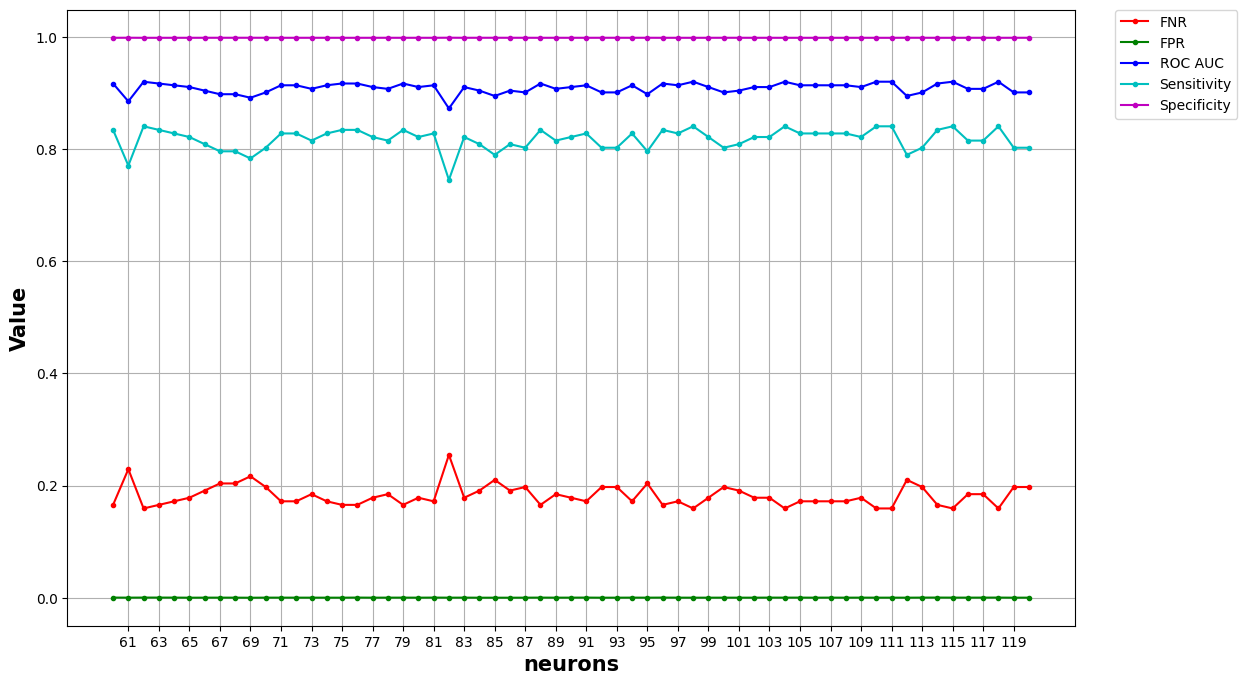

In [78]:
resultPlot('neurons', layer2, fnrs_2, fprs_2, roc_aucs_2, sensitivities_2, specificities_2)

In [98]:
batch_sizes = np.linspace(10, 250, 26).astype(int)

fnrs_3 = []
fprs_3 = []
roc_aucs_3 = []
sensitivities_3 = []
specificities_3 = []

for batch_size in batch_sizes:
    mlp = MLPClassifier(solver='adam', hidden_layer_sizes=[56, 62, ], max_iter=250, batch_size=batch_size, random_state = seed)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_3.append(fnr)
    fprs_3.append(fpr)
    roc_aucs_3.append(roc_auc)
    sensitivities_3.append(sensitivity)
    specificities_3.append(specificity)

In [103]:
batch_sizes = np.linspace(10, 250, 25).astype(int)
batch_sizes

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250])

In [99]:
min_fnr = 100
best_param = 0
for i in range(len(fnrs_3)):
    if (fprs_3[i] * 100 < 0.5 and fnrs_3[i] < min_fnr):
        min_fnr = fnrs_3[i]
        best_param = i
        
print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnrs_3[best_param] * 100, fprs_3[best_param] * 100))
print("ROC AUC = {:.4f}".format(roc_aucs_3[best_param] * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivities_3[best_param] * 100, specificities_3[best_param] * 100))

print("Best batch size = {}".format(batch_sizes[best_param]))

best_batch_size = batch_sizes[best_param]

mlp2 = MLPClassifier(solver='adam', hidden_layer_sizes=[56, 62, ], max_iter=250, batch_size=best_batch_size, random_state = seed)
mlp2.fit(X_train, y_train)
y_pred_best = mlp2.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best, labels=[1,0])
cm

FNR = 14.6497%, FPR = 0.0256%
ROC AUC = 92.6624
sensitivity = 85.3503%, specificity = 99.8574%
Best batch size = 96


array([[  134,    23],
       [   24, 93806]], dtype=int64)

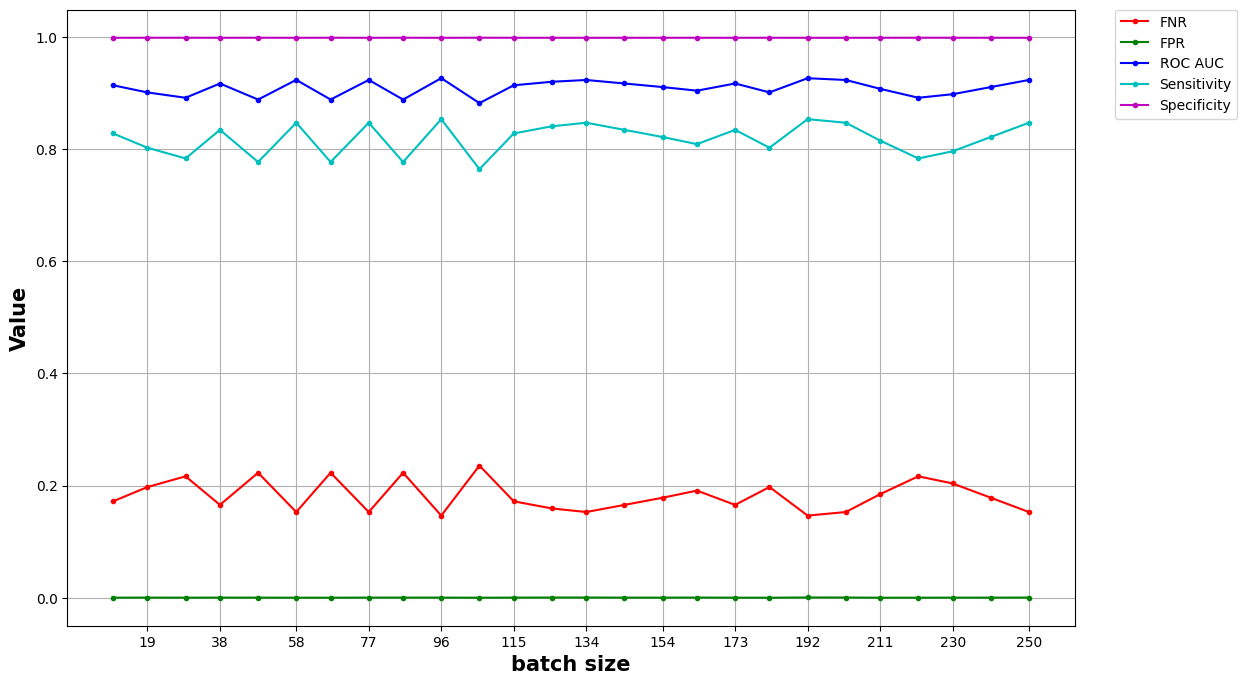

In [101]:
resultPlot('batch size', batch_sizes, fnrs_3, fprs_3, roc_aucs_3, sensitivities_3, specificities_3)

In [94]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=[56, 62,], max_iter=250, batch_size=50, random_state = seed)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)

In [95]:
fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr * 100, fpr * 100))
print("ROC AUC = {:.4f}".format(roc_auc * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity * 100, specificity * 100))

FNR = 13.3758%, FPR = 0.0330%
ROC AUC = 93.2956
sensitivity = 86.6242%, specificity = 99.8552%


In [96]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
cm

array([[  136,    21],
       [   31, 93799]], dtype=int64)

#  Balancing Classes

### Random under-sampling

In [7]:
from imblearn.under_sampling import RandomUnderSampler

In [8]:
undersampled_dataframe = RandomUnderSampler(random_state=seed).fit_resample(X_train, y_train)

X_train_und, y_train_und = undersampled_dataframe

print(y_train_und.value_counts())

0    335
1    335
Name: Class, dtype: int64


In [9]:
mlp_und = MLPClassifier(solver='adam', hidden_layer_sizes=[56, 62,], max_iter=250, batch_size=50, random_state = seed)
mlp_und.fit(X_train_und,y_train_und)

y_pred_und = mlp_und.predict(X_test)

cm_und = confusion_matrix(y_test, y_pred_und, labels=[1,0])
cm_und

array([[  146,    11],
       [ 4527, 89303]], dtype=int64)

In [10]:
fnr_und, fpr_und, roc_auc_und, sensitivity_und, specificity_und = model_metrics(y_test, y_pred_und)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_und * 100, fpr_und * 100))
print("ROC AUC = {:.4f}".format(roc_auc_und))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_und * 100, specificity_und * 100))

FNR = 7.0064%, FPR = 4.8247%
ROC AUC = 0.9408
sensitivity = 92.9936%, specificity = 99.8368%


### Random over-sampling

In [11]:
from imblearn.over_sampling  import RandomOverSampler

In [12]:
oversampled_dataframe = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)

X_train_ov, y_train_ov = oversampled_dataframe

print(y_train_ov.value_counts())

0    190485
1    190485
Name: Class, dtype: int64


In [13]:
mlp_ov= MLPClassifier(solver='adam', hidden_layer_sizes=[56, 62,], max_iter=250, batch_size=50, random_state = seed)
mlp_ov.fit(X_train_ov,y_train_ov)

y_pred_ov = mlp_ov.predict(X_test)

cm_ov = confusion_matrix(y_test, y_pred_ov, labels=[1,0])
cm_ov

array([[  131,    26],
       [   52, 93778]], dtype=int64)

In [14]:
fnr_ov, fpr_ov, roc_auc_ov, sensitivity_ov, specificity_ov = model_metrics(y_test, y_pred_ov)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_ov * 100, fpr_ov * 100))
print("ROC AUC = {:.4f}".format(roc_auc_ov))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_ov * 100, specificity_ov * 100))

FNR = 16.5605%, FPR = 0.0554%
ROC AUC = 0.9169
sensitivity = 83.4395%, specificity = 99.8605%


### Smote over-sampling

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
SMOTE_dataframe = SMOTE(random_state=seed).fit_resample(X_train, y_train)

X_train_SMOTE, y_train_SMOTE = SMOTE_dataframe

print(y_train_SMOTE.value_counts())

0    190485
1    190485
Name: Class, dtype: int64


In [17]:
mlp_SMOTE= MLPClassifier(solver='adam', hidden_layer_sizes=[56, 62,], max_iter=250, batch_size=50, random_state = seed)
mlp_SMOTE.fit(X_train_SMOTE,y_train_SMOTE)

y_pred_SMOTE = mlp_SMOTE.predict(X_test)

cm_SMOTE = confusion_matrix(y_test, y_pred_SMOTE, labels=[1,0])
cm_SMOTE

array([[  134,    23],
       [   50, 93780]], dtype=int64)

In [18]:
fnr_SMOTE, fpr_SMOTE, roc_auc_SMOTE, sensitivity_SMOTE, specificity_SMOTE = model_metrics(y_test, y_pred_SMOTE)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_SMOTE * 100, fpr_SMOTE * 100))
print("ROC AUC = {:.4f}".format(roc_auc_SMOTE))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_SMOTE * 100, specificity_SMOTE * 100))

FNR = 14.6497%, FPR = 0.0533%
ROC AUC = 0.9265
sensitivity = 85.3503%, specificity = 99.8573%


### Cluster Centroids under-smapling

In [19]:
from imblearn.under_sampling import ClusterCentroids

In [20]:
cc_dataframe = ClusterCentroids(random_state=seed).fit_resample(X_train, y_train)

X_train_cc, y_train_cc = cc_dataframe

print(y_train_cc.value_counts())

E:\Projekty\AiED\Projekt\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    335
1    335
Name: Class, dtype: int64


In [21]:
mlp_cc= MLPClassifier(solver='adam', hidden_layer_sizes=[56, 62,], max_iter=250, batch_size=50, random_state = seed)
mlp_cc.fit(X_train_cc,y_train_cc)

y_pred_cc = mlp_cc.predict(X_test)

cm_cc = confusion_matrix(y_test, y_pred_cc, labels=[1,0])
cm_cc

array([[  145,    12],
       [ 3515, 90315]], dtype=int64)

In [22]:
fnr_cc, fpr_cc, roc_auc_cc, sensitivity_cc, specificity_cc = model_metrics(y_test, y_pred_cc)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_cc * 100, fpr_cc * 100))
print("ROC AUC = {:.4f}".format(roc_auc_cc))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_cc * 100, specificity_cc * 100))

FNR = 7.6433%, FPR = 3.7461%
ROC AUC = 0.9431
sensitivity = 92.3567%, specificity = 99.8397%


# Cost-sensitive learning